In [163]:
RKP = "DL031"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import Dropout
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import BatchNormalization
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras

sns.set_theme(style="darkgrid")

In [152]:
# Load datasets and rename columns, load all aqi data but specify metro data name
def loadcsv(city="./data/rkpuram.csv"):
    met = pd.read_csv(city,delimiter=';',skiprows=24)
    aqi = pd.read_csv('./data/station_hour.csv')
    print(aqi.columns)
    met.rename(columns={'# Date': 'Date',}, inplace=True)
    met.rename(columns={'UT time': 'Time',}, inplace=True)
    aqi['Time'] = aqi['Datetime'].str[-8:-3]
    aqi['Date'] = aqi['Datetime'].str[0:10]
    stations = ["DL"+str(x).zfill(3) for x in range(1,39)]
    split_aqi = {}
    for i in range(len(stations)):
        split_aqi[stations[i]] = (aqi[aqi['StationId'] == stations[i]])
    return met,aqi,split_aqi
met,aqi,split_aqi = loadcsv()

c:\users\confusement\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Index(['StationId', 'Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3',
       'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket'],
      dtype='object')


In [179]:
# Pre - processing and loading data
class dataset:
    def __init__(self,met,aqi,split_aqi):
            self.metro_data = met
            self.aqi_data = aqi
            self.split_aqi = split_aqi
    def mergedData(self,station,rlist=['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','AQI'],roll=48,shift=72):
        df_aqi = self.getdf(station)
        df = pd.merge(df_aqi, self.metro_data, how='inner', on=['Date', 'Time'])
        print("Merged Dataset Size",len(df))
        
        #Pre Processing merged Data
        df['Year'] = df['Date'].str[0:4]
        df['Month'] = df['Date'].str[5:7].astype(np.float64)
        df['Day'] = df['Date'].str[8:10].astype(np.float64)
        df['Hour'] = df['Time'].str[0:2]
        
        # TRIG TRANSFORMATIONS
        df['windX'] = np.cos(np.deg2rad(df['Wind direction'])) * df['Wind speed']
        df['windY'] = np.sin(np.deg2rad(df['Wind direction'])) * df['Wind speed']
        df['hourX'] = np.cos((df['Hour'].astype(np.float64)-1)*np.pi/24)
        df['hourY'] = np.sin((df['Hour'].astype(np.float64)-1)*np.pi/24)
        df['MonthX'] = np.cos((df['Month'].astype(np.float64)-1)*np.pi/12)
        df['MonthY'] = np.sin((df['Month'].astype(np.float64)-1)*np.pi/12)
        
        import datetime
        df['Date'] = pd.to_datetime(df['Date'])
        df['isWeekend'] =  (df['Date'].dt.dayofweek>=5).astype(int)
        
        df.interpolate(method='linear', limit=5,inplace=True)
        
        # Drop Additional columns
        df.drop('Benzene', axis=1, inplace=True)
        df.drop('Toluene',axis=1, inplace=True)
        df.drop('Xylene', axis=1,inplace=True)
        df.drop('AQI_Bucket',axis=1,inplace=True)
        df.drop('Datetime',axis=1,inplace=True)
        df.drop('StationId',axis=1,inplace=True)
        df.drop('Short-wave irradiation',axis=1,inplace=True)
        df.drop('Date',axis=1,inplace=True)
        df.drop('Time',axis=1,inplace=True)
        
        # Rolling and shifting 
        print("Size before roll",len(df))
        rollList = ['PM2.5','PM10','NO','NO2','CO','AQI','Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
        for i in rollList:
            df[i+'_lagroll1'] = df[i].rolling(window=24, min_periods=12).mean().shift(6)
            df[i+'_lagroll2'] = df[i].rolling(window=24, min_periods=12).mean().shift(12)
            df[i+'_lagroll3'] = df[i].rolling(window=24, min_periods=12).mean().shift(18)
            df[i+'_lagroll4'] = df[i].rolling(window=24, min_periods=12).mean().shift(24)
            
        for i in rlist:
            df[i+'_lag1'] = df[i].shift(24)
            df[i+'_lag2'] = df[i].shift(48)
            df[i+'_lag3'] = df[i].shift(72)
        for i in rlist:
            df[i+"_pred1"] = df[i].shift(-24)
            df[i+"_pred2"] = df[i].shift(-48)
            df[i+"_pred3"] = df[i].shift(-72)
        newlist = rlist + ['Temperature','Relative Humidity','windX','windY']
        for i in newlist:
            for j in range(24):
                df[i+"_t-"+str(j)] = df[i].shift(j)
                df[i+"_t+"+str(j)] = df[i].shift(-j-shift)
        futurelist = ['Year','MonthX','MonthY','hourX','hourY','isWeekend']
        for i in futurelist:
            for j in range(24):
                df[i+"_t-"+str(j)] = df[i].shift(-(shift+23-j))
        df.dropna(inplace=True)
        print("Size after roll",len(df))
        
        return df.copy()
    def getdf(self,station):
        return self.split_aqi[station]
    def plot(self,station):
        df = self.getdf(station)
    def stats(self):
        pass

In [192]:
# CNN Model Testing as well
def getSplitFeaturesTimeSeries(df,TIME_SERIES_LENGTH = 24):
    features = []
    rlist=['PM2.5','PM10','NO','NO2','CO','AQI']
    for it in rlist:
        print(it,np.mean(df[it]),np.std(df[it]))
    newlist = rlist + ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
    for j in range(24):
        for i in newlist:
            features.append(i+'_t-'+str(j))
    predVector = []
    for j in range(24):
        predVector.append('PM2.5_t+'+str(j))
    X = df[features]
    y = df[predVector]
    X = np.array(X).reshape(X.shape[0],TIME_SERIES_LENGTH,len(newlist))
    scaler = StandardScaler()
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)
    Xtrain = scaler.fit_transform(Xtrain.reshape(Xtrain.shape[0],TIME_SERIES_LENGTH*len(newlist)))
    Xtrain = Xtrain.reshape(Xtrain.shape[0],TIME_SERIES_LENGTH,len(newlist))
    Xtest = scaler.transform(Xtest.reshape(Xtest.shape[0],TIME_SERIES_LENGTH*len(newlist)))
    Xtest = Xtest.reshape(Xtest.shape[0],TIME_SERIES_LENGTH,len(newlist))
    return Xtrain,ytrain,Xtest,ytest
def getSplitFeatures(df):
    features = []
    rlist=['PM2.5','PM10','NO','NO2','CO','AQI']
    for it in rlist:
        print(it,np.mean(df[it]),np.std(df[it]))
    newlist = rlist + ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
    for j in range(1,5):
        for i in newlist:
            features.append(i+'_lagroll'+str(j))
    print("features length",len(newlist))
    predVector = ['PM2.5_t+0']
    X = df[features]
    y = df[predVector]
    X = np.array(X)
    scaler = StandardScaler()
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)
    Xtrain = scaler.fit_transform(Xtrain)
    Xtest = scaler.transform(Xtest)
    return Xtrain,ytrain,Xtest,ytest

In [174]:
def trainModel1(Xtrain,ytrain,Xtest,ytest,TIME_SERIES_LENGTH=24):
    model = Sequential()
    # model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(TIME_SERIES_LENGTH,len(newlist))))
    model.add(Conv1D(128, 3,activation='relu',input_shape=(TIME_SERIES_LENGTH,len(newlist))))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 6,activation='relu',input_shape=(TIME_SERIES_LENGTH,len(newlist))))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 6,activation='relu',input_shape=(TIME_SERIES_LENGTH,len(newlist))))
    model.add(BatchNormalization())

    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    
    # model.add(LSTM(200,activation='relu',input_shape=(TIME_SERIES_LENGTH,len(newlist))))
    # model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(TIME_SERIES_LENGTH,len(newlist))))
    # model.add(Dense(200, activation='relu'))
    
    model.add(Dense(24, activation='relu'))
    model.summary()
    #Fit
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    history = model.fit(Xtrain, ytrain, epochs=200, batch_size=256,  verbose=1, validation_split=0.2)
    return model,history

In [175]:
def predictStats(model,Xtrain,ytrain,Xtest,ytest):
    testPred = model.predict(Xtest)
    trainPred = model.predict(Xtrain)
    print(mean_squared_error(testPred, ytest,squared=False))
    print(mean_squared_error(trainPred, ytrain,squared=False))
    print(mean_absolute_error(testPred, ytest))
    print(mean_absolute_error(trainPred, ytrain))
def plothistory(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for loss
    plt.plot(np.sqrt(history.history['loss']))
    plt.plot(np.sqrt(history.history['val_loss']))
    plt.title('model loss')
    plt.ylabel('RMSE loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

# Run Below for time series models

Merged Dataset Size 44035
Size before roll 44035
Size after roll 12746
PM2.5 101.98476789313264 82.24685447030713
PM10 215.97489333970944 141.24129293818078
NO 43.57018346193662 83.25087922077859
NO2 58.654915716109564 40.60985358453989
CO 1.5801772332177046 2.3063151059462434
AQI 224.31361799780322 111.71448247715317
Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_120 (Conv1D)          (None, 22, 128)           6272      
_________________________________________________________________
batch_normalization_102 (Bat (None, 22, 128)           512       
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 17, 128)           98432     
_________________________________________________________________
batch_normalization_103 (Bat (None, 17, 128)           512       
_______________________________________________________________

Epoch 36/200
27/27 [==============================] - 4s 148ms/step - loss: 880.7792 - mse: 880.7792 - mae: 20.8292 - val_loss: 982.2567 - val_mse: 982.2567 - val_mae: 21.6437
Epoch 37/200
27/27 [==============================] - 4s 150ms/step - loss: 863.8290 - mse: 863.8290 - mae: 20.6099 - val_loss: 979.3203 - val_mse: 979.3203 - val_mae: 21.3911
Epoch 38/200
27/27 [==============================] - 4s 163ms/step - loss: 843.4086 - mse: 843.4086 - mae: 20.4171 - val_loss: 950.5804 - val_mse: 950.5804 - val_mae: 21.3109
Epoch 39/200
27/27 [==============================] - 4s 140ms/step - loss: 833.3428 - mse: 833.3428 - mae: 20.2106 - val_loss: 896.8322 - val_mse: 896.8322 - val_mae: 20.8596
Epoch 40/200
27/27 [==============================] - 5s 167ms/step - loss: 802.4127 - mse: 802.4127 - mae: 19.8442 - val_loss: 856.5181 - val_mse: 856.5181 - val_mae: 20.2160
Epoch 41/200
27/27 [==============================] - 4s 150ms/step - loss: 778.1418 - mse: 778.1418 - mae: 19.5359 - va

27/27 [==============================] - 4s 157ms/step - loss: 367.7048 - mse: 367.7048 - mae: 13.3939 - val_loss: 473.2642 - val_mse: 473.2642 - val_mae: 14.9900
Epoch 83/200
27/27 [==============================] - 4s 158ms/step - loss: 377.4418 - mse: 377.4418 - mae: 13.6981 - val_loss: 435.4294 - val_mse: 435.4294 - val_mae: 14.2308
Epoch 84/200
27/27 [==============================] - 4s 153ms/step - loss: 351.9258 - mse: 351.9258 - mae: 13.0754 - val_loss: 429.5078 - val_mse: 429.5078 - val_mae: 14.0446
Epoch 85/200
27/27 [==============================] - 4s 160ms/step - loss: 352.3631 - mse: 352.3631 - mae: 13.0969 - val_loss: 462.4547 - val_mse: 462.4547 - val_mae: 14.6569
Epoch 86/200
27/27 [==============================] - 4s 164ms/step - loss: 356.8940 - mse: 356.8940 - mae: 13.2316 - val_loss: 415.7231 - val_mse: 415.7231 - val_mae: 13.7158
Epoch 87/200
27/27 [==============================] - 4s 152ms/step - loss: 343.2411 - mse: 343.2411 - mae: 12.9281 - val_loss: 424.7

27/27 [==============================] - 4s 149ms/step - loss: 245.2249 - mse: 245.2249 - mae: 11.0689 - val_loss: 361.5123 - val_mse: 361.5123 - val_mae: 12.9751
Epoch 129/200
27/27 [==============================] - 4s 132ms/step - loss: 248.0695 - mse: 248.0695 - mae: 11.2813 - val_loss: 320.7560 - val_mse: 320.7560 - val_mae: 12.0607
Epoch 130/200
27/27 [==============================] - 4s 148ms/step - loss: 227.0330 - mse: 227.0330 - mae: 10.7006 - val_loss: 314.9121 - val_mse: 314.9121 - val_mae: 11.7872
Epoch 131/200
27/27 [==============================] - 4s 154ms/step - loss: 221.0694 - mse: 221.0694 - mae: 10.5510 - val_loss: 311.3075 - val_mse: 311.3075 - val_mae: 11.8349
Epoch 132/200
27/27 [==============================] - 4s 149ms/step - loss: 236.9973 - mse: 236.9973 - mae: 10.9363 - val_loss: 320.4540 - val_mse: 320.4540 - val_mae: 12.1801
Epoch 133/200
27/27 [==============================] - 3s 128ms/step - loss: 230.7816 - mse: 230.7816 - mae: 10.8315 - val_loss: 

27/27 [==============================] - 4s 157ms/step - loss: 176.5504 - mse: 176.5504 - mae: 9.6564 - val_loss: 267.7699 - val_mse: 267.7699 - val_mae: 11.0184
Epoch 175/200
27/27 [==============================] - 4s 156ms/step - loss: 168.1906 - mse: 168.1906 - mae: 9.4416 - val_loss: 265.7704 - val_mse: 265.7704 - val_mae: 11.0047
Epoch 176/200
27/27 [==============================] - 4s 149ms/step - loss: 180.7781 - mse: 180.7781 - mae: 9.8089 - val_loss: 302.8242 - val_mse: 302.8242 - val_mae: 11.6544
Epoch 177/200
27/27 [==============================] - 4s 137ms/step - loss: 172.9539 - mse: 172.9539 - mae: 9.6079 - val_loss: 288.0204 - val_mse: 288.0204 - val_mae: 11.6655
Epoch 178/200
27/27 [==============================] - 4s 151ms/step - loss: 167.6932 - mse: 167.6932 - mae: 9.4524 - val_loss: 275.0854 - val_mse: 275.0854 - val_mae: 11.1013
Epoch 179/200
27/27 [==============================] - 4s 151ms/step - loss: 171.4711 - mse: 171.4711 - mae: 9.4560 - val_loss: 274.35

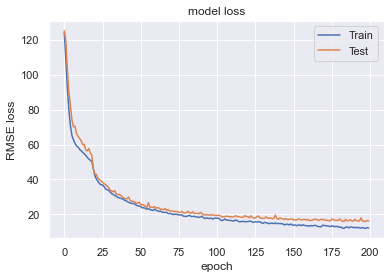

In [167]:
dat = dataset(met,aqi,split_aqi)
df = dat.mergedData('DL031',roll=48,shift=48)
Xtrain,ytrain,Xtest,ytest = getSplitFeaturesTimeSeries(df,TIME_SERIES_LENGTH = 24)
model,history = trainModel1(Xtrain,ytrain,Xtest,ytest,TIME_SERIES_LENGTH=24)
model.save('2daypm1_366')

# reconstructed_model = keras.models.load_model("2daypm1_366")
# predictStats(reconstructed_model,Xtrain,ytrain,Xtest,ytest)

predictStats(model,Xtrain,ytrain,Xtest,ytest)

plothistory(history)

# Run below for non time series model (rolling mean)

In [193]:
# dat = dataset(met,aqi,split_aqi)
# df = dat.mergedData('DL031',roll=48,shift=48)
Xtrain,ytrain,Xtest,ytest = getSplitFeatures(df)
print(Xtrain.shape,ytrain.shape,Xtest.shape,ytest.shape)
# predictStats(model,Xtrain,ytrain,Xtest,ytest)

PM2.5 101.89062177480847 82.2323519352033
PM10 215.52704148344912 140.97411211440493
NO 43.47371008555342 83.06738197153933
NO2 58.66296373444158 40.64878421077701
CO 1.5791442652531407 2.3089151644232633
AQI 224.23316853135833 111.67767090442183
features length 16
(8503, 64) (8503, 1) (4189, 64) (4189, 1)


In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression , mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
dfTrain = df[:]
features = ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
features.append("PM2.5_lag1")
features.append("PM2.5_lag2")

features.append("PM10_lag1")
features.append("PM10_lag2")

features.append("NO2_lag1")
features.append("NO2_lag2")

features.append("SO2_lag1")
features.append("SO2_lag2")

features.append("NO_lag1")
features.append("NO_lag2")

features.append("NOx_lag1")
features.append("NOx_lag2")

# features.append("CO_lag1")
# features.append("CO_lag2")

# features.append("O3_lag1")
# features.append("O3_lag2")

# features.append("NH3_lag1")
# features.append("NH3_lag2")

# features = []
# rlist=['PM2.5','PM10','NO','NO2','CO']
# newlist = rlist + ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
# for i in newlist:
#     for j in range(24):
#         features.append(i+'_t-'+str(j))
        
X = df[features]
y = df['PM2.5_pred3']
scaler = StandardScaler()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)
scaler.fit(Xtrain)

reg = LinearRegression().fit(scaler.transform(Xtrain), ytrain)

testPred = reg.predict(scaler.transform(Xtest))
trainPred = reg.predict(scaler.transform(Xtrain))
mse = np.mean((testPred - np.array(ytest))*(testPred - np.array(ytest)))
print(reg.score(scaler.transform(Xtest), ytest))
print(mean_squared_error(testPred, ytest,squared=False))
print(mean_squared_error(trainPred, ytrain,squared=False))
print(mean_absolute_error(testPred, ytest))
print(mean_absolute_error(trainPred, ytrain))

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression , mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
dfTrain = df[:]
features = ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
features.append("PM2.5_lag1")
features.append("PM2.5_lag2")

features.append("PM10_lag1")
features.append("PM10_lag2")

features.append("NO2_lag1")
features.append("NO2_lag2")

features.append("SO2_lag1")
features.append("SO2_lag2")

features.append("NO_lag1")
features.append("NO_lag2")

features.append("NOx_lag1")
features.append("NOx_lag2")

features.append("CO_lag1")
features.append("CO_lag2")

features.append("O3_lag1")
features.append("O3_lag2")

features.append("NH3_lag1")
features.append("NH3_lag2")

features = []
rlist=['PM2.5','PM10','NO','NO2','CO']
newlist = rlist + ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
for i in newlist:
    for j in range(24):
        features.append(i+'_t-'+str(j))
        
X = df[features]
y = df['PM2.5_pred1']
scaler = StandardScaler()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)
scaler.fit(Xtrain)

reg = MLPRegressor(random_state=1, max_iter=100).fit(scaler.transform(Xtrain), ytrain)

testPred = reg.predict(scaler.transform(Xtest))
trainPred = reg.predict(scaler.transform(Xtrain))
mse = np.mean((testPred - np.array(ytest))*(testPred - np.array(ytest)))
print(reg.score(scaler.transform(Xtest), ytest))
print(mean_squared_error(testPred, ytest,squared=False))
print(mean_squared_error(trainPred, ytrain,squared=False))

In [126]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression , mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
dfTrain = df[:]
features = ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
features.append("PM2.5_lag1")
features.append("PM2.5_lag2")

features.append("PM10_lag1")
features.append("PM10_lag2")

features.append("NO2_lag1")
features.append("NO2_lag2")

features.append("SO2_lag1")
features.append("SO2_lag2")

features.append("NO_lag1")
features.append("NO_lag2")

features.append("NOx_lag1")
features.append("NOx_lag2")

features.append("CO_lag1")
features.append("CO_lag2")

features.append("O3_lag1")
features.append("O3_lag2")

features.append("NH3_lag1")
features.append("NH3_lag2")

features = []
rlist=['PM2.5','PM10','NO','NO2','CO']
newlist = rlist + ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
for i in newlist:
    for j in range(24):
        features.append(i+'_t-'+str(j))

X = df[features]
y = df['PM2.5_pred1']
scaler = StandardScaler()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)
print(Xtrain.shape,ytrain.shape)
# scaler.fit(Xtrain)

reg = SVR(C=3.0, epsilon=0.2).fit(Xtrain, ytrain)

testPred = reg.predict(Xtest)
trainPred = reg.predict(Xtrain)
mse = np.mean((testPred - np.array(ytest))*(testPred - np.array(ytest)))
print(reg.score(Xtest, ytest))
print(mean_squared_error(testPred, ytest,squared=False))
print(mean_squared_error(trainPred, ytrain,squared=False))
print(mean_absolute_error(testPred, ytest))
print(mean_absolute_error(trainPred, ytrain))

(7769, 360) (7769,)
0.3379685723175532
65.78093011534429
67.0801815314519
43.41983467544137
43.25189223855267


In [ ]:
import tensorflow as tf  
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
features = ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
features = []
rlist=['PM2.5','PM10','NO','NO2','CO']
newlist = rlist + ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
for i in newlist:
    for j in range(24):
        features.append(i+'_t-'+str(j))
predVector = []
for j in range(24):
    predVector.append('PM2.5_t+'+str(j))
X = df[features]
y = df[predVector]
scaler = StandardScaler()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)
scaler.fit(Xtrain)
print(Xtrain.shape)
model = Sequential()
model.add(Dense(200, input_dim=360, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(24, activation='linear'))
model.summary()
#Fit
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
history = model.fit(scaler.transform(Xtrain), ytrain, epochs=100, batch_size=50,  verbose=1, validation_split=0.2)
#Print Accuracy
testPred = model.predict(scaler.transform(Xtest))
trainPred = model.predict(scaler.transform(Xtrain))
print(mean_squared_error(testPred, ytest,squared=False))
print(mean_squared_error(trainPred, ytrain,squared=False))
print(mean_absolute_error(testPred, ytest))
print(mean_absolute_error(trainPred, ytrain))

In [ ]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(np.sqrt(history.history['loss']))
plt.plot(np.sqrt(history.history['val_loss']))
plt.title('model loss')
plt.ylabel('RMSE loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()